# PyTorch
We will build a few straightforward neural nets on PyTorch to test out the efficacy of the framework.

In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn, optim
from PIL import Image

## Building neural nets using PyTorch
The first step is **parameter initialization**; the weights and bias parameters for each layer are initialized as tensor variables.

In [ ]:
n_input, n_hidden, n_output = 5, 3, 1

In [ ]:
# initialize tensor for inputs and outputs
x = torch.randn((1, n_input))
y = torch.randn((1, n_output))

# initialize tensor variables for weights
w1 = torch.randn(n_input, n_hidden)
w2 = torch.randn(n_hidden, n_output)

# initialize tensor variables for bias terms
b1 = torch.randn((1, n_hidden))
b2 = torch.randn((1, n_output))

Defining and training a neural network in four key steps:
- Forward Propagation
- Loss computation
- Backpropagation
- Updating parameters

**Forward Propagation**: Activations are calculated at every layer using the two steps shown below. These activations flow in the forward direction from the input layer to the output layer in order to generate the final output.
1. z = weight * input + bias
2. a = activation_function(z)

In [ ]:
# sigmoid activation function using pytorch
def sigmoid_activation(z):
  return 1/(1+torch.exp(-z))

In [ ]:
# activation of hidden layer
z1 = torch.mm(x, w1) + b1
a1 = sigmoid_activation(z1)

In [ ]:
# output of final layer
z2 = torch.mm(a1, w2) + b2
output = sigmoid_activation(z2)

**Loss Computation**: Error/Loss is calculated in the output layer.

In [ ]:
loss = y - output

**Backpropagation**: The aim of this step is to minimize the error in the output layer by making marginal changes in the bias and weights; computed using the derivatives of the error term.

In [ ]:
# function to calculate the derivative of activation
def sigmoid_delta(x):
  return x * (1-x)

In [ ]:
# compute derivative of error terms
delta_output = sigmoid_delta(output)
delta_hidden = sigmoid_delta(a1)

In [ ]:
# pass the changes back to previous layers
d_outp = loss * delta_output
loss_h = torch.mm(d_outp, w2.t())
d_hidn = loss_h * delta_hidden

**Updating parameters**: Finally, the weights and biases are updated using the delta changes received from the above backpropagation step.

In [ ]:
learning_rate = 0.1

In [ ]:
w2 += torch.mm(a1.t(), d_outp) * learning_rate
w1 += torch.mm(x.t(), d_hidn) * learning_rate

In [ ]:
b2 += d_outp.sum() * learning_rate
b1 += d_hidn.sum() * learning_rate

Most importantly, these steps must be executed for a number of epochs with a large number of training examples to reduce the loss to a minimum value. With the final weights and biases obtained by such a process, predictions can be made on unseen data.

## Example case 1: handwritten digital classification
We will create a **Multi-Layered Perceptron (MLP) network** for building a handwritten digit classifier.

In [ ]:
# transforms
_tasks = transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.5,), (0.5,))
])

_tasks

Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)

The first transformation converts the raw data into tensor variables, and the second transformation performs normalization; the values 0.5 and 0.5 represent mean and standard deviation for the single channel (grayscale).

In [ ]:
# load MNIST, apply transformations
mnist = MNIST('data', download=True, train=True, transform=_tasks)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!





/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [ ]:
# create training and validation split
split = int(0.8 * len(mnist))
index_list = list(range(len(mnist)))
train_idx, valid_idx = index_list[:split], index_list[split:]

In [ ]:
# create sampler objects using SubsetRandomSampler
tr_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(valid_idx)

In [ ]:
# DataLoader iterator
trainloader = DataLoader(mnist, batch_size=256, sampler=tr_sampler)
validloader = DataLoader(mnist, batch_size=256, sampler=val_sampler)

We will define the network with the following layer configurations: [784, 128, 10]

This configuration represents:
- 784 nodes (28 * 28 pixels)
- 128 hidden layers
- 10 in output layer

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden = nn.Linear(784, 128)
    self.output = nn.Linear(128, 10)
  
  def forward(self, x):
    x = self.hidden(x)
    x = torch.sigmoid(x)
    x = self.output(x)
    return x

In [ ]:
model = Model()

Define loss function and optimizer.

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-6,
    nesterov=True
    )

Train model.

In [ ]:
for epoch in range(10):
  train_loss, valid_loss = [], []
  # training
  model.train()
  for data, target in trainloader:
    data = data.view(data.shape[0], -1)
    optimizer.zero_grad()
    # forward propagation
    output = model(data)
    # loss calculation
    loss = loss_function(output, target)
    # backward propagation
    loss.backward()
    # weight optimization
    optimizer.step()

    train_loss.append(loss.item())

  # evaluation
  model.eval()
  for data, target in validloader:
    data = data.view(data.shape[0], -1)
    output = model(data)
    loss = loss_function(output, target)
    valid_loss.append(loss.item())

  print('Epoch: {}'.format(epoch),
        'Training Loss: {}'.format(np.mean(train_loss)),
        'Validation Loss: {}'.format(np.mean(valid_loss)))

Epoch: 0 Training Loss: 1.42264420713516 Validation Loss: 0.7039201716159252
Epoch: 1 Training Loss: 0.5730196663990934 Validation Loss: 0.44724075527901347
Epoch: 2 Training Loss: 0.43011905379751897 Validation Loss: 0.37316732710980355
Epoch: 3 Training Loss: 0.37486380505117967 Validation Loss: 0.3389719217381579
Epoch: 4 Training Loss: 0.3439139508186503 Validation Loss: 0.31405793923012754
Epoch: 5 Training Loss: 0.32226504575698933 Validation Loss: 0.29851274319151616
Epoch: 6 Training Loss: 0.30723253574143067 Validation Loss: 0.2861251066973869
Epoch: 7 Training Loss: 0.2938732995473324 Validation Loss: 0.27484682519385156
Epoch: 8 Training Loss: 0.2824264465969928 Validation Loss: 0.2661603635295908
Epoch: 9 Training Loss: 0.2724466107468656 Validation Loss: 0.2585597447258361


Making predictions on the validation set (should preferably be a holdout set instead).

In [ ]:
# dataloader for validation set
data, labels = next(iter(validloader))
data = data.view(data.shape[0], -1)
output = model(data)

In [ ]:
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy())

In [ ]:
print('Actual: {}'.format(labels[:10]))
print('Predicted: {}'.format(preds[:10]))

Actual: tensor([2, 1, 7, 0, 1, 9, 9, 8, 8, 8])
Predicted: [2 1 7 0 1 9 9 8 5 8]


## Example case 2: object image classification
We will create a **Convolutional Neural Network (CNN)** architecture in PyTorch; the goal is to perform object image classification using the CIFAR-10 dataset.

In [ ]:
# load the dataset
cifar = CIFAR10('data', train=True, download=True, transform=_tasks)

Extracting data/cifar-10-python.tar.gz to data


In [ ]:
# create training and validation split
split = int(0.8*len(cifar))
index_list = list(range(len(cifar)))
train_idx, valid_idx = index_list[:split], index_list[split:]

In [ ]:
# create training and validation sampler objects
tr_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(valid_idx)

In [ ]:
# dataloader iterator objects for train and valid datasets
trainloader = DataLoader(cifar, batch_size=256, sampler=tr_sampler)
validloader = DataLoader(cifar, batch_size=256, sampler=val_sampler)

We create the architecture with the following characteristics:
- Three convolutional layers (for low level feature extraction)
- Three pooling layers (for maximum information extraction)
- Two linear layers (for linear classification)

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    # define the layers
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.linear1 = nn.Linear(1024, 512)
    self.linear2 = nn.Linear(512, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    # reshape
    x = x.view(-1, 1024)
    x = F.relu(self.linear1(x))
    x = self.linear2(x)
    return x

model = Model()

Define loss function and optimizer.

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-6,
    nesterov=True
)

In [ ]:
# run for 30 epochs
for epoch in range(30):
  train_loss, valid_loss = [], []

  # training
  model.train()
  for data, target in trainloader:
    optimizer.zero_grad()
    output = model(data)
    loss = loss_function(output, target)
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())

  # evaluation
  model.eval()
  for data, target in validloader:
    output = model(data)
    loss = loss_function(output, target)
    valid_loss.append(loss.item())

  print('Epoch: {}'.format(epoch),
        'Train Loss: {}'.format(np.mean(train_loss)),
        'Validation Loss: {}'.format(np.mean(valid_loss)))

Epoch: 0 Train Loss: 1.9133514811278909 Validation Loss: 1.6955921471118927
Epoch: 1 Train Loss: 1.5646305289238123 Validation Loss: 1.53147534430027
Epoch: 2 Train Loss: 1.3937338712109122 Validation Loss: 1.4228034347295762
Epoch: 3 Train Loss: 1.267292220121736 Validation Loss: 1.2456122994422913
Epoch: 4 Train Loss: 1.1548720097086231 Validation Loss: 1.3190075755119324
Epoch: 5 Train Loss: 1.062666348211325 Validation Loss: 1.2363319486379623
Epoch: 6 Train Loss: 0.978830342080183 Validation Loss: 1.130150893330574
Epoch: 7 Train Loss: 0.9096235382329126 Validation Loss: 1.0665551885962485
Epoch: 8 Train Loss: 0.844228498115661 Validation Loss: 1.0541755855083466
Epoch: 9 Train Loss: 0.7822909609527345 Validation Loss: 0.995457997918129
Epoch: 10 Train Loss: 0.7259207333728765 Validation Loss: 0.9456400722265244
Epoch: 11 Train Loss: 0.6763025772799353 Validation Loss: 0.9471479460597039
Epoch: 12 Train Loss: 0.621743765796066 Validation Loss: 1.0029581367969513
Epoch: 13 Train Lo

In [ ]:
# dataloader for validation dataset
data, labels = next(iter(validloader))
output = model(data)

_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy())

In [ ]:
print('Actual: {}'.format(labels[:10]))
print('Predicted: {}'.format(preds[:10]))

Actual: tensor([3, 8, 2, 2, 9, 8, 6, 7, 0, 6])
Predicted: [3 8 4 2 9 8 6 2 0 6]


## Example case 3: image style transfer
The basic idea behind the [style transfer concept](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) is:
- Take objects/context from one image
- Take style/texture from a seconf image
- Generate a final image which is a mixture of the two

1. Low level feature extraction from both the input images: can be done using pretrained deep learning models such as VGG19

In [2]:
# get the features portion from VGG19
vgg = models.vgg19(pretrained=True).features

# freeze VGG parameters
for param in vgg.parameters():
  param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [3]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Load the two images on the device and obtain the features from VGG. Also, apply the transformation:
- Resize to tensor
- Normalization of values

In [4]:
def transformation(img):
  tasks = transforms.Compose([
                              transforms.Resize(400),
                              transforms.ToTensor(),
                              transforms.Normalize((0.44, 0.44, 0.44), (0.22, 0.22, 0.22))
  ])
  img = tasks(img)[:3, :, :].unsqueeze(0)
  return img

In [5]:
img1 = Image.open('./sample_data/pool.jpg').convert('RGB')
img2 = Image.open('./sample_data/impression.jpg').convert('RGB')

In [6]:
img1 = transformation(img1).to(device)
img2 = transformation(img2).to(device)

We need to obtain the relevant features of the two images:
- Image one: extract features related to the context or the objects
- Image two: extract features related to styles and textures

In [7]:
def get_features(image, model):
  layers = {
      '0': 'conv1_1',
      '5': 'conv2_1',
      '10': 'conv3_1',
      '19': 'conv4_1',
      '21': 'conv4_2',
      '28': 'conv5_1'
  }
  x = image
  features = {}
  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers:
      features[layers[name]] = x
  return features

In [8]:
img1_features = get_features(img1, vgg)
img2_features = get_features(img2, vgg)

The authors of the linked paper used used correlations in different layers to obtain the style related features. These feature correlations are givrn by the Gram matrix G; every cell (i, j) in G is the inner product between vectorized feature maps i and j in a layer.

In [9]:
def correlation_matrix(tensor):
  _, d, h, w = tensor.size()
  tensor = tensor.view(d, h*w)
  correlation = torch.mm(tensor, tensor.t())
  return correlation

In [10]:
correlations = {l: correlation_matrix(img2_features[l]) for l in img2_features}

We can now perform style transfer using features and correlations. We need to set the weight of every layer used to obtain style features to transfer style from one image to another. The initial layers provide more information so we'll set more weights for these layers. Also, define the optimizer function and the target imafe which will be the copy of image 1.

In [12]:
weights = {
    'conv1_1': 1.0,
    'conv2_1': 0.8,
    'conv3_1': 0.25,
    'conv4_1': 0.21,
    'conv5_1': 0.18
}

target = img1.clone().requires_grad_(True).to(device)
optimizer = optim.Adam([target], lr=0.003)

Start loss minimization process; run the loop for a large number of steps and calculate the loss related to object feature extraction and style feature extraction. Using the minimized loss, the network parameters are updated which further updates the target image.

In [13]:
for ii in range(20000):
  # calculate the content loss (from image 1 and target)
  target_features = get_features(target, vgg)
  loss = target_features['conv4_2'] - img1_features['conv4_2']
  content_loss = torch.mean((loss)**2)

  # calculate the style loss (from image 2 and target)
  style_loss = 0
  for layer in weights:
    target_feature = target_features[layer]
    target_corr = correlation_matrix(target_feature)
    style_corr = correlations[layer]

    layer_loss = torch.mean((target_corr - style_corr)**2)
    layer_loss *= weights[layer]

    _, d, h, w = target_feature.shape
    style_loss += layer_loss/(d*h*w)
  
  total_loss = 1e6 * style_loss + content_loss

  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  print('Iteration: {}'.format(ii),
        'Total Loss: {}'.format(total_loss))

Streaming output truncated to the last 5000 lines.
Iteration: 15001 Total Loss: 30265.884765625
Iteration: 15002 Total Loss: 30307.962890625
Iteration: 15003 Total Loss: 30256.875
Iteration: 15004 Total Loss: 30127.353515625
Iteration: 15005 Total Loss: 29983.38671875
Iteration: 15006 Total Loss: 29896.09765625
Iteration: 15007 Total Loss: 29898.697265625
Iteration: 15008 Total Loss: 29966.580078125
Iteration: 15009 Total Loss: 30043.53515625
Iteration: 15010 Total Loss: 30085.380859375
Iteration: 15011 Total Loss: 30080.1796875
Iteration: 15012 Total Loss: 30054.1015625
Iteration: 15013 Total Loss: 30036.044921875
Iteration: 15014 Total Loss: 30052.416015625
Iteration: 15015 Total Loss: 30106.234375
Iteration: 15016 Total Loss: 30196.68359375
Iteration: 15017 Total Loss: 30314.927734375
Iteration: 15018 Total Loss: 30451.908203125
Iteration: 15019 Total Loss: 30576.697265625
Iteration: 15020 Total Loss: 30654.986328125
Iteration: 15021 Total Loss: 30635.505859375
Iteration: 15022 Tota

View predicted/transfered results.

In [14]:
def tensor_to_image(tensor):
  image = tensor.to('cpu').clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1, 2, 0)
  image *= np.array((0.22, 0.22, 0.22)) + np.array((0.44, 0.44, 0.44))
  image = image.clip(0, 1)
  return image

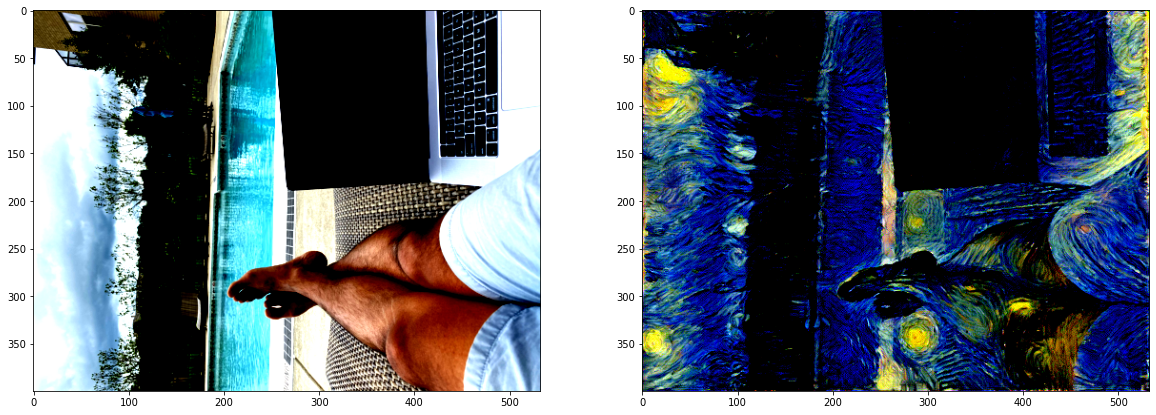

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
ax1.imshow(tensor_to_image(img1))
ax2.imshow(tensor_to_image(target))